In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
%matplotlib inline

# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [2]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [3]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Price" price. Do you see any patterns, long-term and/or short?

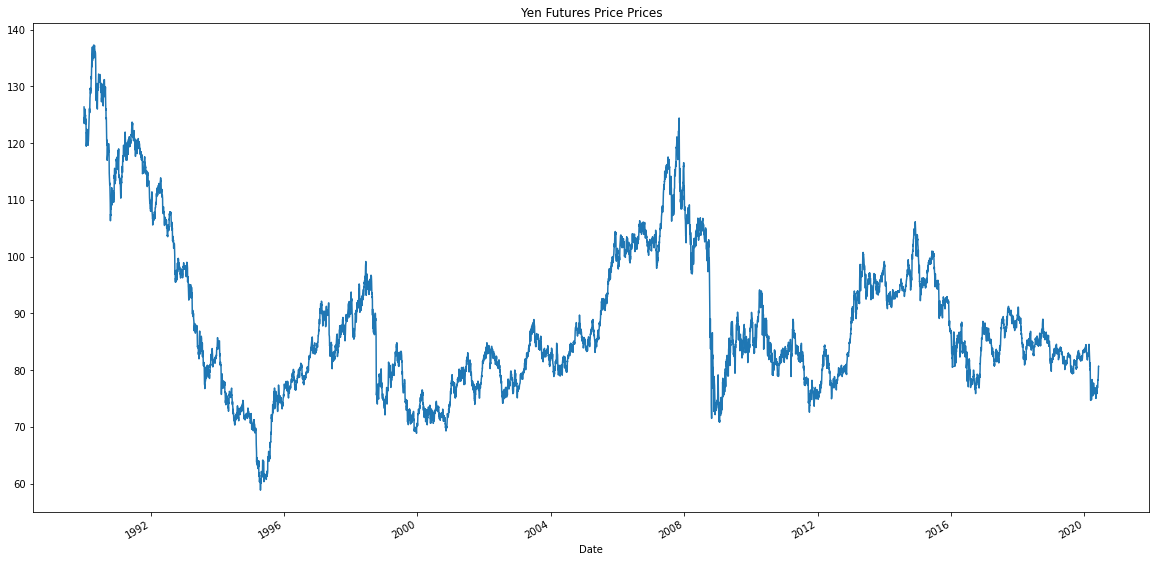

In [4]:
# Plot just the "Price" column from the dataframe:
yen_futures['Price'].plot(title='Yen Futures Price Prices',figsize=(20,10))

*Answer*
 * Based on the plot above, we can see a long-term strengthening of the Japanese Yen against the Dollar. There do seem to be some more medium, 1-3 year consistent trends, but on a daily basis, there are a lot of short-term ups and downs.

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Price price into a trend and noise.

In [5]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the "Price" price into two separate series:
yen_noise, yen_trend = sm.tsa.filters.hpfilter(yen_futures['Price'])

In [6]:
# Create a dataframe of just the Price price, and add columns for "noise" and "trend" series from above:
yen_hp_data = yen_futures['Price'].to_frame()
yen_hp_data['noise'] = yen_noise
yen_hp_data['trend'] = yen_trend
yen_hp_data.head()

,Price,noise,trend
Date,,,
1990-01-02,126.37,0.519095,125.850905
1990-01-03,125.30,-0.379684,125.679684
1990-01-04,123.46,-2.048788,125.508788
1990-01-05,124.54,-0.798304,125.338304
1990-01-08,124.27,-0.897037,125.167037


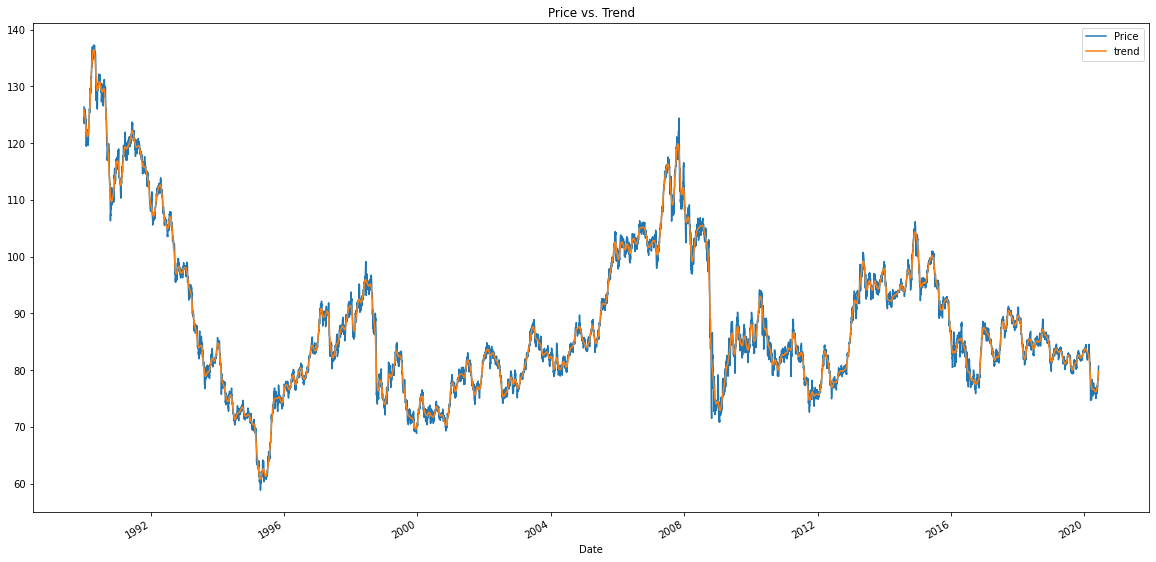

In [7]:
# Plot the Price Price vs. the Trend
yen_hp_data.plot(y=['Price','trend'],figsize=(20,10),title='Price vs. Trend')

Smoothing with the HP Filter and plotting the resulting trend against the actual futures returns, we can see that there's a lot of short term fluctuations that deviate around this trend. Perhaps these would represent profitable trading opportunities: For example, when the blue line deviates far below the orange, we can see this as a sign that the Yen is temporarily more undervalued than it should be (and, therefore, we'd see this as a short-term buying opportunity).

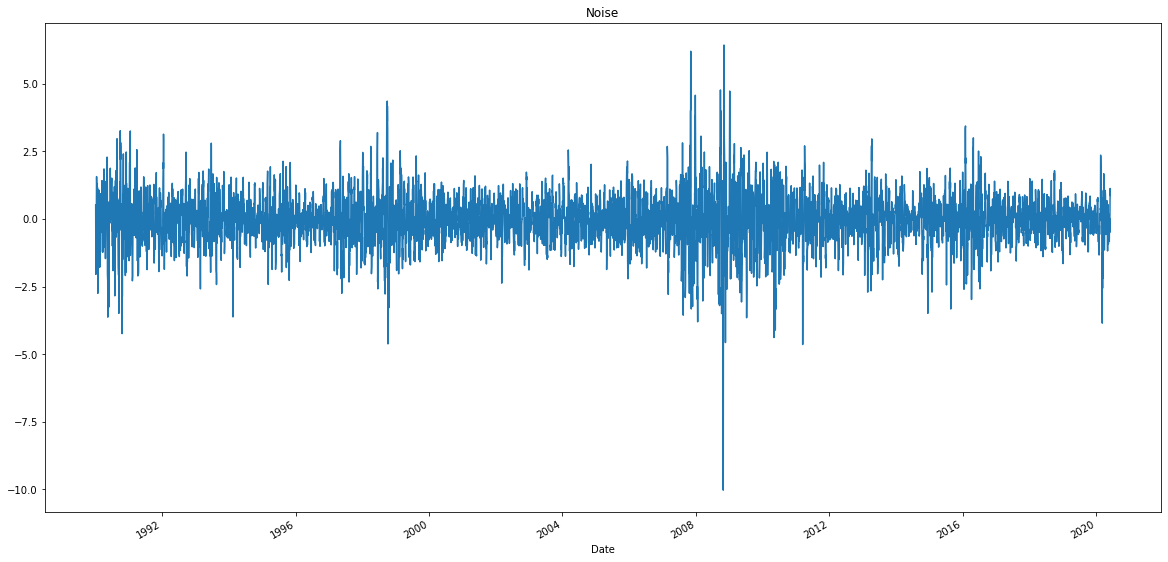

In [8]:
# Plot the Price Noise
yen_hp_data['noise'].plot(figsize=(20,10),title='Noise')

---

# Forecasting Returns using an ARMA Model

Using futures Price *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [9]:
# Create a series using "Price" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Price"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Price
Date,
2020-05-29,0.076697
2020-06-01,1.251756
2020-06-02,1.425508
2020-06-03,0.373134
2020-06-04,0.012392


In [10]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA

# Estimate and ARMA model using statsmodels (use order=(2, 1))
model = ARMA(returns.values, order=(1,1))

# Fit the model and assign it to a variable called results
results = model.fit()

In [11]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7928
Model:                     ARMA(1, 1)   Log Likelihood               -9752.112
Method:                       css-mle   S.D. of innovations              0.828
Date:                Wed, 24 Mar 2021   AIC                          19512.224
Time:                        15:28:33   BIC                          19540.136
Sample:                             0   HQIC                         19521.782
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.009     -0.256      0.798      -0.019       0.015
ar.L1.y        0.6429      0.240      2.674      0.007       0.172       1.114
ma.L1.y       -0.6668      0.234     -2.850      0.004      -1.125      -0.208
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.5555           +0.0000j            1.5555            0.0000
MA.1            1.4996           +0.0000j            1.4996            0.0000
-----------------------------------------------------------------------------
"""

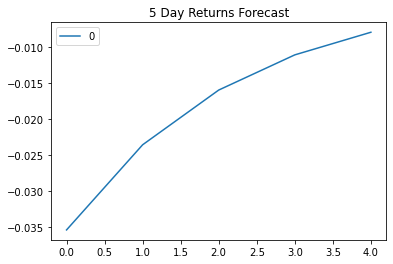

In [12]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Returns Forecast")

Question: Based on the p-value, is the model a good fit?

Answer:

# Yes - the p-value is less than than 0.05

---

# Forecasting the Price Price using an ARIMA Model

 1. Using the *raw* Yen **Price Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Price Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [13]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(yen_futures["Price"].values, order=(5, 1, 1))

# Fit the model
results = model.fit()

In [14]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 7928
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -8745.622
Method:                       css-mle   S.D. of innovations              0.729
Date:                Wed, 24 Mar 2021   AIC                          17507.244
Time:                        15:28:37   BIC                          17563.070
Sample:                             1   HQIC                         17526.361
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0058      0.008     -0.743      0.458      -0.021       0.009
ar.L1.D.y      0.4287      0.246      1.740      0.082      -0.054       0.912
ar.L2.D.y      0.0177      0.014      1.264      0.206      -0.010       0.045
ar.L3.D.y     -0.0118      0.012     -0.959      0.337      -0.036       0.012
ar.L4.D.y      0.0110      0.012      0.879      0.379      -0.013       0.035
ar.L5.D.y     -0.0191      0.011     -1.702      0.089      -0.041       0.003
ma.L1.D.y     -0.4568      0.246     -1.855      0.064      -0.939       0.026
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7660           -0.7702j            1.9266           -0.0655
AR.2            1.7660           +0.7702j            1.9266            0.0655
AR.3           -2.3649           -0.0000j            2.3649           -0.5000
AR.4           -0.2974           -2.4212j            2.4394           -0.2695
AR.5           -0.2974           +2.4212j            2.4394            0.2695
MA.1            2.1893           +0.0000j            2.1893            0.0000
-----------------------------------------------------------------------------
"""

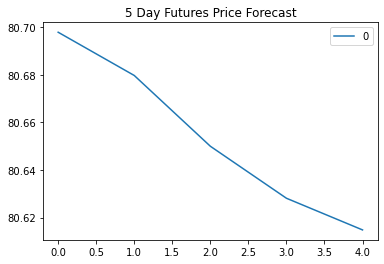

In [15]:
# Plot the 5 Day Price Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title='5 Day Futures Price Forecast')

What does the model forecast will happen to the Japanese Yen in the near term?

# That it will weaken against the dollar. Today a CAD can buy ¥80.70, and in 5 days the model predicts that a dollar will now be able to buy ¥80.62. 

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Price *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [18]:
!pip install arch
import arch as arch
from arch import arch_model

  Using cached property_cached-1.6.4-py2.py3-none-any.whl (7.8 kB)


In [19]:
# Estimate a GARCH model:
model = arch_model(returns, mean="Zero", vol="GARCH", p=1, q=1)

# Fit the model
results = model.fit(disp="off")

In [20]:
# Summarize the model results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8911.02
Distribution:                  Normal   AIC:                           17828.0
Method:            Maximum Likelihood   BIC:                           17849.0
                                        No. Observations:                 7928
Date:                Wed, Mar 24 2021   Df Residuals:                     7928
Time:                        15:31:16   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      9.0734e-03  2.401e-03      3.779  1.573e-04 [4.368e-03,1.378e-02]
alpha[1]       0.0624  9.003e-03      6.936  4.035e-12 [4.480e-02,8.009e-02]
beta[1]        0.9243  1.110e-02     83.250      0.000     [  0.903,  0.946]
============================================================================

Covariance estimator: robust
"""

In [21]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2020-06-04'

In [22]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
forecasts = results.forecast(start=last_day, horizon=forecast_horizon)

C:\Users\visha\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


In [23]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2020-06-04,12.566007,12.573696,12.581279,12.588757,12.596132


In [24]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2020-06-04
h.1,12.566007
h.2,12.573696
h.3,12.581279
h.4,12.588757
h.5,12.596132


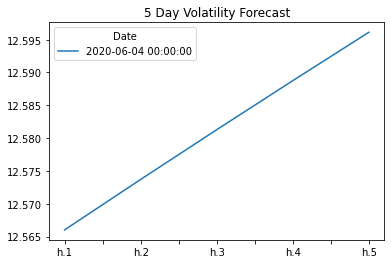

In [25]:
# Plot the final forecast
final.plot(title='5 Day Volatility Forecast')

---

# Conclusions

Based on your time series analysis, would you buy the yen now?

Is the risk of the yen expected to increase or decrease?

Based on the model evaluation, would you feel confident in using these models for trading?

# Given that returns on the yen are projected to decrease, the value of the yen is supposed to weaken against the CAD, and volatility / risk is supposed to rise, I would hold on investing on yen at this time. 

# Yes I feel confident based on the analysis above.